# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Flatten, Dense, \
    AveragePooling2D, AvgPool2D, \
    GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

x, y = next(train_gen_flow)

Found 7591 validated image filenames.


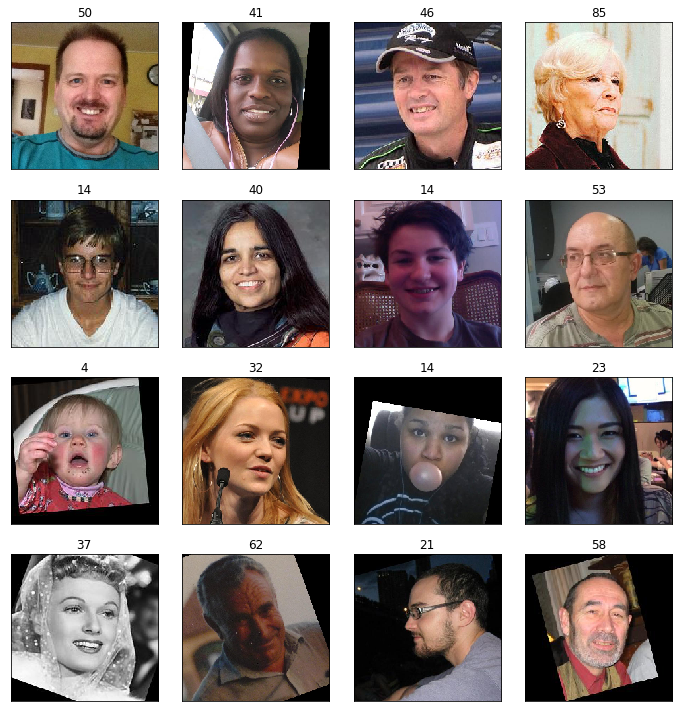

In [3]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(x[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.title(y[i])
    plt.tight_layout()

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


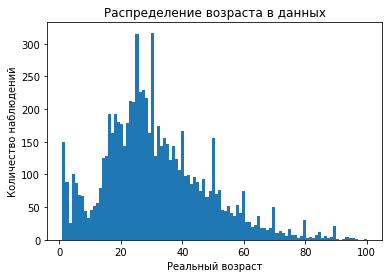

In [9]:
plt.hist(labels['real_age'], bins=100)
plt.title('Распределение возраста в данных')
plt.xlabel('Реальный возраст')
plt.ylabel('Количество наблюдений')
plt.show()

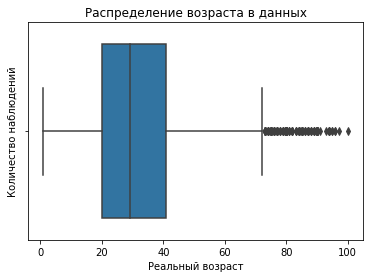

In [8]:
sns.boxplot(x=labels['real_age'])
plt.title('Распределение возраста в данных')
plt.xlabel('Реальный возраст')
plt.ylabel('Количество наблюдений')
plt.show()

В наборе преобладают фотографии людей в возрасте от 20 до 40 лет, тогда как представителей других возрастов меньше. 

Присутствуют изображения низкого качества, где с трудом можно разлечить лица а так же фото с артефактами, поворотами и прочими искажениями.

Это может сказаться на качестве предсказаний.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
2021-08-01 04:53:15.615695: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-08-01 04:53:15.897876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 45s - loss: 213.4570 - mae: 11.1069 - val_loss: 511.4228 - val_mae: 17.5353
Epoch 2/20
356/356 - 38s - loss: 137.8377 - mae: 8.9912 - val_loss: 354.4237 - val_mae: 14.1664
Epoch 3/20
356/356 - 38s - loss: 114.2117 - mae: 8.1207 - val_loss: 140.6651 - val_mae: 9.4606
Epoch 4/20
356/356 - 37s - loss: 98.1092 - mae: 7.5131 - val_loss: 110.5613 - val_mae: 8.1830
Epoch 5/20
356/356 - 38s - loss: 84.7906 - mae: 7.0448 - val_loss: 105.2934 - val_mae: 7.9251
Epoch 6/20
356/356 - 37s - loss: 70.6852 - mae: 6.4517 - val_loss: 121.6378 - val_mae: 8.5015
Epoch 7/20
356/356 - 38s - loss: 64.4993 - mae: 6.1564 - val_loss: 176.1856 - val_mae: 10.7760
Epoch 8/20
356/356 - 38s - loss: 52.6640 - mae: 5.6083 - val_loss: 96.0366 - val_mae: 7.4629
Epoch 9/20
356/356 - 38s - loss: 44.7036 - mae: 5.1235 - val_loss: 98.9394 - val_mae: 7.4886
Epoch 10/20
356/356 - 38s - loss: 37.7752 - mae: 4.7236 - val_loss: 100.1429 - val_mae: 7.4388
Epoch 11/20
356/356 - 38s - loss: 31.4976 - mae: 4.3121 - val_loss: 96.1654 - val_mae: 7.6090
Epoch 12/20
356/356 - 38s - loss: 29.1445 - mae: 4.1506 - val_loss: 97.9753 - val_mae: 7.3915
Epoch 13/20
356/356 - 38s - loss: 25.9536 - mae: 3.8895 - val_loss: 114.3848 - val_mae: 7.9804
Epoch 14/20
356/356 - 38s - loss: 24.3241 - mae: 3.8083 - val_loss: 90.3310 - val_mae: 7.1771
Epoch 15/20
356/356 - 37s - loss: 22.7251 - mae: 3.6446 - val_loss: 98.8411 - val_mae: 7.4262
Epoch 16/20
356/356 - 38s - loss: 22.4291 - mae: 3.6714 - val_loss: 87.9728 - val_mae: 7.0154
Epoch 17/20
356/356 - 38s - loss: 22.4375 - mae: 3.5957 - val_loss: 90.4112 - val_mae: 7.2873
Epoch 18/20
356/356 - 38s - loss: 19.3633 - mae: 3.4060 - val_loss: 82.8320 - val_mae: 6.9853
Epoch 19/20
356/356 - 38s - loss: 19.2918 - mae: 3.3576 - val_loss: 87.4913 - val_mae: 7.0627
Epoch 20/20
356/356 - 38s - loss: 18.2380 - mae: 3.2605 - val_loss: 78.3857 - val_mae: 6.7206

```

## Анализ обученной модели

Был получен неплохой результат MAE на 20 эпохе - 6.7206 при использовании архитектуры ResNet.

Данная модель позволит довольно неплохо решать задачу рапсознавания возраста покупателей, а значит снизит нагрузку на кассиров и время на проверку документов.

Кроме того - данная модель будет неплохим подспорьем для маркетологов в составлении потребительской корзины покупателей определенного возраста.